# Wavelet estimator on Cavanagh dataset

In [1]:
using CSV
using DataFrames
using LinearAlgebra
using Plots
using Statistics
using GLM

In [2]:
alt = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8];

### Functions

In [3]:
function extract_P_DT(dataset)
    Pᵒ = zeros(6,6)
    DTᵒ = zeros(6,6)
    mask = Array{Bool}([1 1 1; 1 0 1; 1 0 1; 1 0 1; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0])
    
    for i in 1:10
        if mask[i,1]
            alt1 = dataset[i,1]
            alt2 = dataset[i,2]
            idx1 = findfirst(alt .== alt1)
            idx2 = findfirst(alt .== alt2)
            Pᵒ[idx1, idx2] = dataset[i, 4]
            Pᵒ[idx2, idx1] = 1 - Pᵒ[idx1, idx2]
            DTᵒ[idx1, idx2] = dataset[i, 7]
            DTᵒ[idx2, idx1] = DTᵒ[idx1, idx2]
        end

        if mask[i,2]
            alt1 = dataset[i,2]
            alt2 = dataset[i,3]
            idx1 = findfirst(alt .== alt1)
            idx2 = findfirst(alt .== alt2)
            Pᵒ[idx1, idx2] = dataset[i, 5]
            Pᵒ[idx2, idx1] = 1 - Pᵒ[idx1, idx2]
            DTᵒ[idx1, idx2] = dataset[i, 8]
            DTᵒ[idx2, idx1] = DTᵒ[idx1, idx2]
        end

        if mask[i,3]
            alt1 = dataset[i,1]
            alt2 = dataset[i,3]
            idx1 = findfirst(alt .== alt1)
            idx2 = findfirst(alt .== alt2)
            Pᵒ[idx1, idx2] = dataset[i, 6]
            Pᵒ[idx2, idx1] = 1 - Pᵒ[idx1, idx2]
            DTᵒ[idx1, idx2] = dataset[i, 9]
            DTᵒ[idx2, idx1] = DTᵒ[idx1, idx2]
        end
    end
    return Pᵒ,DTᵒ
end

extract_P_DT (generic function with 1 method)

In [4]:
# Analysis functions

#find which alternatives are actually compared to "a" in the experiment
function getComp(a::Int64, obs::Matrix{Float64}) 
    choice_set = collect(1:size(obs)[1])
    (sum(abs.(obs[a,:])) == Inf) && return choice_set[abs.(obs[a,:]) .!= Inf]      #observable is l or DT
    (obs[a,a] == 0.5) && return choice_set[obs[a,:] .!= 0.0]                       #observable is P - ALWAYS USE THIS FOR COMPLETE DATASETS!!!!
    return choice_set
end


function get_l(P::Matrix{Float64})
    l = log.(P ./ (1 .- P))
    return l
end

#l
function l_tilde(a::Int64, b::Int64, l::Matrix{Float64}, obs::Matrix{Float64})
    C_a = getComp(a, obs)
    C_b = getComp(b, obs)
    C = intersect(Set(C_a), Set(C_b))
    l̃ = 0
    N = length(C)
    N == 0 && return (false, -Inf) #a and b are not connected in the transitive comparison graph
    for c in C
        l̃ += (l[a,c] + l[c,b])
    end
    return (true, l̃/N)
end


function l_tilde(l::Matrix{Float64}, obs::Matrix{Float64})
    n = size(l)[1]
    L̃ = -Inf .* ones(n,n)
    for a in 1:n
        @assert abs(l_tilde(a,a,l,obs)[2]) < 1e-7 
        L̃[a,a] = 0.0
        for b in (a+1):n
            conn, l̃ = l_tilde(a,b,l,obs)
            if !conn
                L̃[a,b] = L̃[b,a] = -Inf
            else
                L̃[a,b] = l̃
                L̃[b,a] = -l̃
            end
        end
    end
    conn = (L̃ .> -Inf)  #if l̃[a,b] is -Inf, it means that a and b are not neighbors
    return L̃, conn
end

# DT
function DT_tilde(a::Int64, b::Int64, l::Matrix{Float64}, DT::Matrix{Float64})
    A_l = (l .> -Inf)    #i.e. conn (in the l-step, not in the DT-step)
    A_dt = (DT .< Inf)
    @assert (A_l .& A_dt) == A_dt    #i.e. A_dt <= A_l
    n = size(A_l)[1]
    !A_l[a,b] && return Inf
    a == b && return 0.0  #impose diagonal, think more about it later
    
    R = abs(l[a,b]) * (exp(abs(l[a,b])) + 1) / (exp(abs(l[a,b])) - 1)
    res = 0.0
    for c in 1:n
        for d in (c+1):n
            if A_dt[c,d]
                k = abs(l[c,d])
                r = k * (exp(k) + 1) / (exp(k) - 1)
                res += DT[c,d] * r
            end
        end
    end
    return res / (R * (sum(A_dt) - n) / 2)
end

function DT_tilde(l::Matrix{Float64}, DT::Matrix{Float64})
    n = size(DT)[1]
    DT_t = Inf .* ones(n,n)
    for a in 1:n
        for b in a:n
            DT_t[a,b] = DT_tilde(a,b,l,DT)
            DT_t[b,a] = DT_t[a,b]
        end
    end
    return DT_t
end

DT_tilde (generic function with 2 methods)

**Caveat with l_tilde compared to Shevlin et al: I had to base getComp() on the P observable instead of the l observable, this should be debugged more.**

In [5]:
# smoothing functions for complete datasets

function l_tilde_comp(l::Matrix{Float64})
    n = size(l)[1]
    l_til = -Inf .* ones(n,n)
    
    for a in 1:n
        for b in a:n
            l_til[a,b] = 0.0
            
            (a == b) && (abs(sum(l[a,:] + l[:,a])) < 1e-7) && continue
            
            for c in 1:n
                l_til[a,b] += (l[a,c] + l[c,b]) 
            end
            l_til[a,b] /= n
            l_til[b,a] = -l_til[a,b]
        end
    end
    return l_til
end

function DT_tilde_comp(l::Matrix{Float64}, DT::Matrix{Float64})
    n = size(DT)[1]
    DT_til = Inf .* ones(n,n)
    for a in 1:n
        for b in a:n
            R = abs(l[a,b]) * (exp(abs(l[a,b])) + 1) / (exp(abs(l[a,b])) - 1)
            DT_til[a,b] = 0.0
            (a == b) && continue
            for c in 1:n
                for d in (c+1):n 
                    k = abs(l[c,d])
                    DT_til[a,b] += DT[c,d] * k * (exp(k) + 1) / (exp(k) - 1)
                end
            end
            DT_til[a,b] /= (R*n*(n-1)/2)
            DT_til[b,a] = DT_til[a,b]
        end
    end
    return DT_til
end

DT_tilde_comp (generic function with 1 method)

In [6]:
#Wavelet

function wavelet(l::Matrix{Float64}, DT::Matrix{Float64}, new::Bool = true)
    @assert size(l)[1] == size(l)[2] == size(DT)[1] == size(DT)[2]
    n = size(l)[1]
    conn = (l .> -Inf)
    @assert conn == (DT .< Inf)
    
    if new
        k = abs(l[1,2])
        λ = DT[1,2] * k * (exp(k) + 1) / (exp(k) - 1)
    else
        λ = 0
        edges = (sum(conn) - n) / 2
        for a in 1:n
            for b in (a+1):n
                if conn[a,b]
                    k = abs(l[a,b])
                    λ += DT[a,b] * k * (exp(k) + 1) / (exp(k) - 1)
                end
            end
        end
        λ /= edges
    end
    
    return (sqrt(λ), l/sqrt(λ))
end

# function wavelet(l::Matrix{Float64}, DT::Matrix{Float64}, a::Int64=1, b::Int64=1)
#     @assert size(l)[1] == size(l)[2] == size(DT)[1] == size(DT)[2]
#     n = size(l)[1]
#     conn = (l .> -Inf)
#     @assert conn == (DT .< Inf)
    
#     k = abs(l[a,b])
#     λ = DT[a,b] * k * (exp(k) + 1) / (exp(k) - 1)

#     return (sqrt(λ), l/sqrt(λ))
# end

# #this needs to be fixed...
# function wavelet(P::Matrix{Float64}, DT::Matrix{Float64}, mask::BitArray{2})
#     @assert size(P)[1] == size(P)[2] == size(DT)[1] == size(DT)[2]
#     n = size(P)[1]
#     l = log.(P ./ (1 .- P))
#     l[diagind(l)] .= 0
#     l̃, conn = l_tilde(l, P)
#     λ = 0
#     edges = sum(conn)/2
#     @assert issymmetric(conn)
#     for a in 1:n
#         for b in (a+1):n
#             if conn[a,b] && mask[a,b]
#                 λ += DT[a,b] * abs(l̃[a,b]) * (exp(abs(l̃[a,b])) + 1) / (exp(abs(l̃[a,b])) - 1)
#             end
#         end
#     end
#     λ /= edges
#     return (sqrt(λ), l̃/sqrt(λ))
# end

wavelet (generic function with 2 methods)

In [7]:
#DDM
DT_DDM(λ::Float64, udiff::Matrix{Float64}) = λ .* tanh.(λ .* udiff ./ 2) ./ udiff
DT_DDM(λ::Float64, udiff::Vector{Float64}) = λ .* tanh.(λ .* udiff ./ 2) ./ udiff
P_DDM(λ::Float64, udiff::Matrix{Float64}) = 1 ./ (1 .+ exp.(-λ.*udiff))
P_DDM(λ::Float64, udiff::Vector{Float64}) = 1 ./ (1 .+ exp.(-λ.*udiff))

P_DDM (generic function with 2 methods)

In [79]:
#visualization

function plot_obs(obs::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64})
    n = size(obs)[1]
    v = lam .* udiff
    idx = (obs .!= 0.0)
    y = obs[idx]
    x = v[idx]
    scatter(x,y)
end

function plot_obs(obs::Matrix{Float64}, v::Matrix{Float64})
    n = size(obs)[1]
    idx = (obs .!= 0.0)
    y = obs[idx]
    x = v[idx]
    scatter(x,y)
end

function plot_P(P::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, save::Bool=false, filename="P_plot_shevlin")
    n = size(P)[1]
    v = udiff
    idx = (P .!= 0.0) .& (P .!= 0.5) .& (v .> 0)
    x = v[idx]
    y = P[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    P_th = P_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed choice freq.", title="Wavelet estimator and empirical data (P)", legend=:topleft, dpi=500)
    plot!(grid, P_th, label = "elicited DDM")
    xlabel!("Δu (elicited)")
    ylabel!("P(a,b)")
  
    save && savefig(fig, filename)
    display(fig)
end

function plot_P(P::Matrix{Float64}, lam::Tuple{Float64}, udiff::Tuple{Matrix{Float64}}, save::Bool=false, filename="P_plot_shevlin")
n = size(P)[1]
    v = udiff
    idx = (P .!= 0.0) .& (P .!= 0.5) .& (v .> 0)
    x = v[idx]
    y = P[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    P_th = P_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed choice freq.", title="Wavelet estimator and empirical data (P)", legend=:topleft, dpi=500)
    plot!(grid, P_th, label = "elicited DDM")
    xlabel!("Δu (elicited)")
    ylabel!("P(a,b)")
  
    save && savefig(fig, filename)
    display(fig)
end


function plot_DT(DT::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, save::Bool=false, filename="DT_plot_shevlin")
    n = size(DT)[1]
    v = udiff
    idx = (DT .< Inf) .& (DT .!= 0) .& (v .> 0)
    x = v[idx]
    y = DT[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    DT_th = DT_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed mean DT", title="Wavelet estimator and empirical data (DT)", dpi=500)
    plot!(grid, DT_th, label = "elicited DDM") 
    xlabel!("Δu (elicited)")
    ylabel!("DT(a,b)")
    save && savefig(fig, filename)
    display(fig)
end

plot_DT (generic function with 3 methods)

---

## Analysis

In [80]:
dataset1 = CSV.read("Datasets/CavanaghDataset.csv", DataFrame)
dataset1 = Matrix(dataset1);

In [81]:
P_c, DT_c = extract_P_DT(dataset1)
P_c[diagind(P_c)] .= 0.5;

In [82]:
P_c

6×6 Matrix{Float64}:
 0.5       0.362179  0.261981  0.106109  0.083871  0.0573248
 0.637821  0.5       0.434505  0.125807  0.163462  0.115756
 0.738019  0.565495  0.5       0.23301   0.140575  0.153846
 0.893891  0.874193  0.76699   0.5       0.506536  0.325806
 0.916129  0.836538  0.859425  0.493464  0.5       0.351613
 0.942675  0.884244  0.846154  0.674194  0.648387  0.5

In [83]:
DT_c

6×6 Matrix{Float64}:
    0.0    1286.85  1285.75   981.942  1044.13   929.42
 1286.85      0.0   1334.77  1086.93   1129.05  1055.03
 1285.75   1334.77     0.0   1168.58   1195.47  1041.3
  981.942  1086.93  1168.58     0.0    1128.91  1057.22
 1044.13   1129.05  1195.47  1128.91      0.0   1047.59
  929.42   1055.03  1041.3   1057.22   1047.59     0.0

In [84]:
l = get_l(P_c)

6×6 Matrix{Float64}:
 0.0       -0.565917  -1.0357    -2.13111    -2.39088    -2.79999
 0.565917   0.0       -0.263495  -1.93856    -1.6327     -2.03325
 1.0357     0.263495   0.0       -1.19139    -1.81052    -1.70475
 2.13111    1.93856    1.19139    0.0         0.0261451  -0.727214
 2.39088    1.6327     1.81052   -0.0261451   0.0        -0.611957
 2.79999    2.03325    1.70475    0.727214    0.611957    0.0

In [85]:
l_til = l_tilde(l, P_c)[1]
l_til2 = l_tilde(l_til, P_c)[1]

l_diff = abs.(l_til2 - l_til)
sum(l_diff[.!isnan.(l_diff)])

3.3861802251067274e-15

In [86]:
sum(abs.(l_til - l_til2))

3.3861802251067274e-15

The function for l_tilde in the incomplete case works just as the one for the complete case, good!

In [87]:
DT_til = DT_tilde(l_til, DT_c)

6×6 Matrix{Float64}:
    0.0    1286.51   1239.25   954.017   930.821   838.105
 1286.51      0.0    1314.43  1090.26   1066.25    965.245
 1239.25   1314.43      0.0   1159.72   1136.9    1036.43
  954.017  1090.26   1159.72     0.0    1324.09   1292.57
  930.821  1066.25   1136.9   1324.09      0.0    1303.71
  838.105   965.245  1036.43  1292.57   1303.71      0.0

In [88]:
DT_til1 = DT_tilde_comp(l_til, DT_c)

6×6 Matrix{Float64}:
    0.0    1286.51   1239.25   954.017   930.821   838.105
 1286.51      0.0    1314.43  1090.26   1066.25    965.245
 1239.25   1314.43      0.0   1159.72   1136.9    1036.43
  954.017  1090.26   1159.72     0.0    1324.09   1292.57
  930.821  1066.25   1136.9   1324.09      0.0    1303.71
  838.105   965.245  1036.43  1292.57   1303.71      0.0

In [89]:
sum(abs.(DT_til - DT_til1))

5.6843418860808015e-12

In [90]:
λ, udiff = wavelet(l_til, DT_til)

(51.48454121648704, [0.0 -0.011723626006055367 … -0.045708176244739766 -0.054387698670204494; 0.011723626006055367 0.0 … -0.0339845502386844 -0.042664072664149115; … ; 0.045708176244739766 0.0339845502386844 … 0.0 -0.008679522425464721; 0.054387698670204494 0.042664072664149115 … 0.008679522425464721 0.0])

## Visualization

To understand how well the Wavelet estimator fits the data, we need to plot it. In particular, we need to plot P and DT as a function of $\lambda \Delta u$

A note on masking on Julia:

Whenever matrices arrays are flattened, the resulting vector is filled column-wise (first column, second column, ..., last column). 

If M = [**a b ... n**], then vec(M) = [**a**\*, **b**\*, ..., **n**\*]

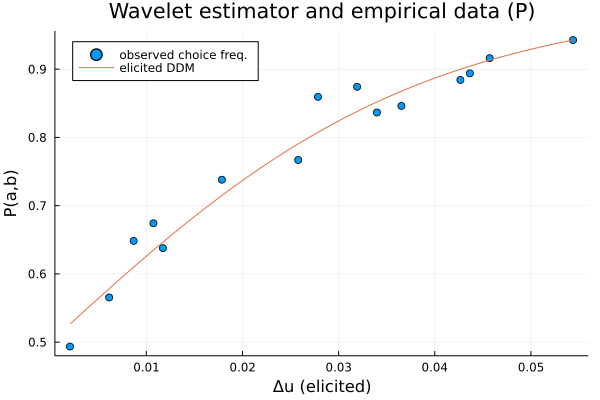

In [91]:
plot_P(P_c, λ, udiff)
savefig("P_whole_Cavanagh_21jan")

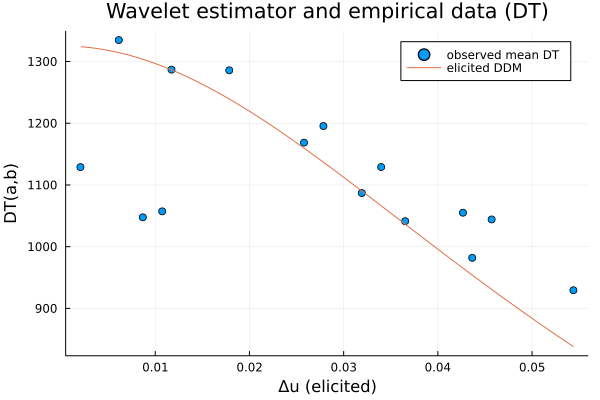

In [92]:
plot_DT(DT_c, λ, udiff)
savefig("DT_whole_Cavanagh_21jan")

## Value vs Utility

In [96]:
vdiff = zeros((6,6))
for a in 1:6
    for b in a:6
        vdiff[a,b] = alt[a] - alt[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end
vdiff

6×6 Matrix{Float64}:
 -0.0  -0.1  -0.2  -0.4  -0.5  -0.6
  0.1  -0.0  -0.1  -0.3  -0.4  -0.5
  0.2   0.1  -0.0  -0.2  -0.3  -0.4
  0.4   0.3   0.2  -0.0  -0.1  -0.2
  0.5   0.4   0.3   0.1  -0.0  -0.1
  0.6   0.5   0.4   0.2   0.1  -0.0

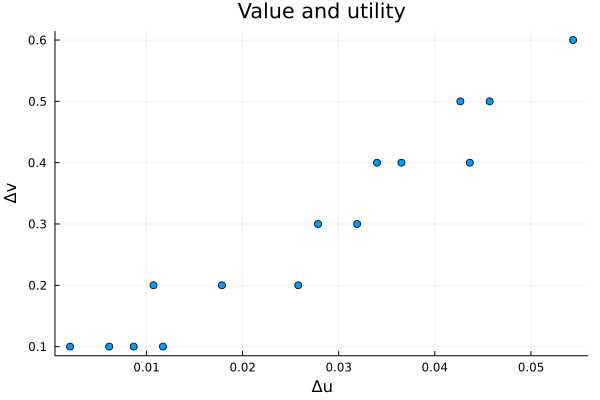

In [97]:
mask = udiff .> 0.0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="")#, dpi=500)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_cavanagh")
display(fig)

In [98]:
data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)

,u,v
,Float64,Float64
1,0.0117236,0.1
2,0.0178569,0.2
3,0.0436493,0.4
4,0.0457082,0.5
5,0.0543877,0.6
6,0.00613327,0.1
7,0.0319257,0.3
8,0.0339846,0.4
9,0.0426641,0.5


In [99]:
ols = lm(@formula(v~u), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

v ~ 1 + u

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.0318326   0.0230578   1.38    0.1907  -0.0179807   0.081646
u            9.81402     0.743898   13.19    <1e-08   8.20692    11.4211
──────────────────────────────────────────────────────────────────────────

In [100]:
b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="", dpi=500)
savefig("v_vs_u_cavanagh_whole_21jan")

---

## Remove win-win comparisons

In [101]:
mask = ([4,5],[4,6],[5,6])

([4, 5], [4, 6], [5, 6])

In [102]:
DT_c1 = copy(DT_c);
P_c1 = copy(P_c);

In [103]:
for pair in mask
    DT_c1[pair[1],pair[2]] = DT_c1[pair[2],pair[1]] = Inf
    P_c1[pair[1],pair[2]] = P_c1[pair[2],pair[1]] = 0.0
end

In [104]:
DT_c1

6×6 Matrix{Float64}:
    0.0    1286.85  1285.75   981.942  1044.13   929.42
 1286.85      0.0   1334.77  1086.93   1129.05  1055.03
 1285.75   1334.77     0.0   1168.58   1195.47  1041.3
  981.942  1086.93  1168.58     0.0      Inf      Inf
 1044.13   1129.05  1195.47    Inf        0.0     Inf
  929.42   1055.03  1041.3     Inf       Inf       0.0

In [105]:
P_c1

6×6 Matrix{Float64}:
 0.5       0.362179  0.261981  0.106109  0.083871  0.0573248
 0.637821  0.5       0.434505  0.125807  0.163462  0.115756
 0.738019  0.565495  0.5       0.23301   0.140575  0.153846
 0.893891  0.874193  0.76699   0.5       0.0       0.0
 0.916129  0.836538  0.859425  0.0       0.5       0.0
 0.942675  0.884244  0.846154  0.0       0.0       0.5

In [106]:
l_out = get_l(P_c1)

6×6 Matrix{Float64}:
 0.0       -0.565917  -1.0357     -2.13111   -2.39088   -2.79999
 0.565917   0.0       -0.263495   -1.93856   -1.6327    -2.03325
 1.0357     0.263495   0.0        -1.19139   -1.81052   -1.70475
 2.13111    1.93856    1.19139     0.0      -Inf       -Inf
 2.39088    1.6327     1.81052   -Inf         0.0      -Inf
 2.79999    2.03325    1.70475   -Inf       -Inf         0.0

In [107]:
l_out_til = l_tilde(l_out, l_out)[1]
l_out_til2 = l_tilde(l_out_til, l_out_til)[1]
l_out_til3 = l_tilde(l_out_til2, l_out_til2)[1]

l_out_diff = abs.(l_out_til3 - l_out_til2)
sum(l_out_diff[.!isnan.(l_out_diff)])

4.6629367034256575e-15

In [108]:
DT_til1 = DT_tilde(l_til, DT_c1)

6×6 Matrix{Float64}:
    0.0    1342.89  1293.56   995.83   971.618   874.838
 1342.89      0.0   1372.03  1138.04  1112.98   1007.55
 1293.56   1372.03     0.0   1210.55  1186.72   1081.86
  995.83   1138.04  1210.55     0.0   1382.12   1349.22
  971.618  1112.98  1186.72  1382.12     0.0    1360.85
  874.838  1007.55  1081.86  1349.22  1360.85      0.0

In [109]:
λ1, udiff1 = wavelet(l_til, DT_til1)

(52.600686099705776, [0.0 -0.011474859950901153 … -0.044738284959669396 -0.0532336347960998; 0.011474859950901153 0.0 … -0.03326342500876825 -0.04175877484519864; … ; 0.044738284959669396 0.03326342500876825 … 0.0 -0.008495349836430395; 0.0532336347960998 0.04175877484519864 … 0.008495349836430395 0.0])

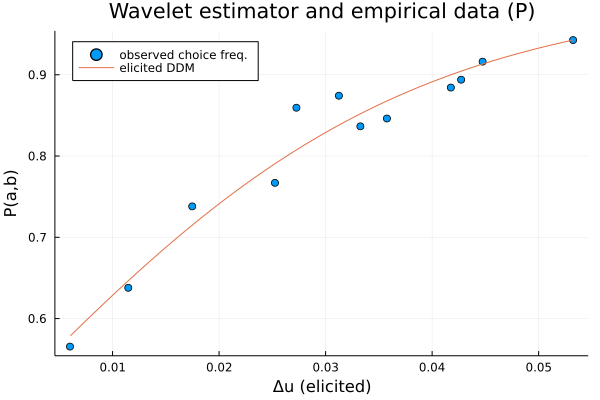

In [110]:
plot_P(P_c1, λ1, udiff1) 
savefig("P_nowinwin_Cavanagh_21jan")

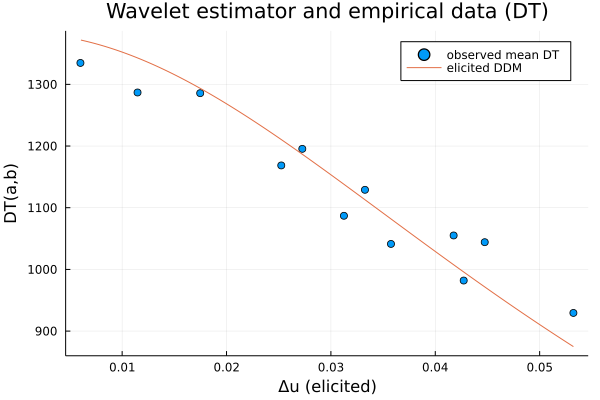

In [111]:
plot_DT(DT_c1, λ1, udiff1)
savefig("DT_nowinwin_Cavanagh_21jan")

In [112]:
vdiff = zeros((6,6))
for a in 1:6
    for b in a:6
        vdiff[a,b] = alt[a] - alt[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end
vdiff

6×6 Matrix{Float64}:
 -0.0  -0.1  -0.2  -0.4  -0.5  -0.6
  0.1  -0.0  -0.1  -0.3  -0.4  -0.5
  0.2   0.1  -0.0  -0.2  -0.3  -0.4
  0.4   0.3   0.2  -0.0  -0.1  -0.2
  0.5   0.4   0.3   0.1  -0.0  -0.1
  0.6   0.5   0.4   0.2   0.1  -0.0

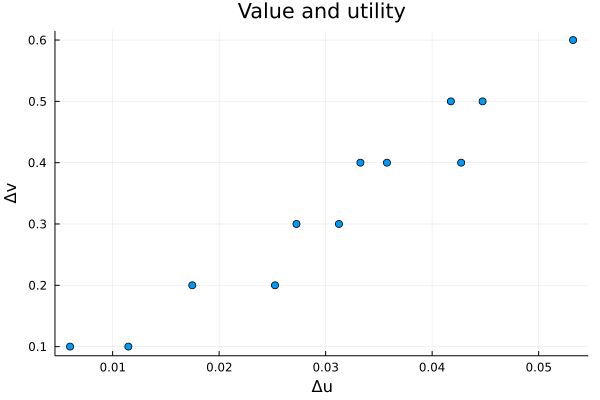

In [113]:
mask = ([4,5],[4,6],[5,6])

for pair in mask
    udiff[pair[1],pair[2]] = udiff[pair[2],pair[1]] = 0.0
end

mask = udiff .> 0.0
u = udiff1[mask]
v = vdiff[mask]


fig = scatter(u, v, title = "Value and utility", label="")#, dpi=500)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_cavanagh")
display(fig)

In [114]:
data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)

,u,v
,Float64,Float64
1,0.0114749,0.1
2,0.017478,0.2
3,0.0427231,0.4
4,0.0447383,0.5
5,0.0532336,0.6
6,0.00600313,0.1
7,0.0312483,0.3
8,0.0332634,0.4
9,0.0417588,0.5


In [41]:
ols = lm(@formula(v~u), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

v ~ 1 + u

Coefficients:
────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -5.62935e-17   0.0081548  -0.00    1.0000  -0.016912   0.016912
u            10.8471        0.242061   44.81    <1e-22  10.3451    11.3491
────────────────────────────────────────────────────────────────────────────

In [115]:
b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="", dpi=500)
savefig("v_vs_u_cavanagh_nowinwin_21jan")